<a href="https://colab.research.google.com/github/kiansiong/exploratory_projects/blob/master/BayesianStats_Effects_of_Prior_on_Posterior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
! pip install arviz
! pip install --upgrade pymc3>=3.8

In [0]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn, binomial, multinomial
from scipy import stats 
import statsmodels as sm
import pymc3 as pm
from pymc3.backends.tracetab import trace_to_dataframe
import seaborn as sns
import warnings
# warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)

# Exploring the effects of the prior on the MAP
We explore various scenerios, to determine the effect of the prior on the MAP solution. 

# Problem 1: Coin Flip (Binomial distribution)

##### **Problem Setup:**
Suppose we want to determine if a coin is fair one. 
We can model this by using a Binomial distribution, where the outcome of Heads=1, and Tails=0. 

##### **Model:**
We can model the outcomes with a Binomial Distribution of N independent trials, and for k samples. ie, 2 coin fiips (N), 5 times (k). For our Prior, we use the Beta distribution as it is conjugate to the Binomial. 

To examine the effect of the prior on MAP, we vary the parameters of the Beta distribution to change the shape of the distribution, reflecting our Prior knowledge. 


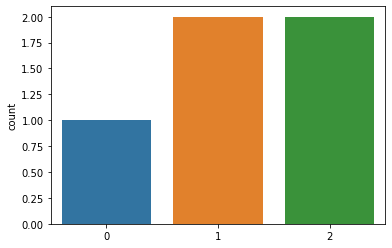

In [49]:
''' Define a Binomial distribution, with a Beta prior '''
np.random.seed(23)

# True parameter value  - Biased coin with 70% chance of Heads
true_p = 0.7

# Sample size; ie. How many independent coin flips in one sample
N = 2

# Number of samples drawn in dataset; ie. How many samples of sample_size=N were drawn
num_samples = 5

# Generate random data based on true_theta
x = binomial(N, true_p, size=num_samples)
sns.countplot(x)

Above plot counts the samples, and the respective number of heads. 

## Uniform Prior - Assume Fair Coin
We sample the data we have with MCMC 1000 times, to generate an estimate for the posterior. The MAP is then the peak of the posterior. 

Sequential sampling (2 chains in 1 job)
NUTS: [p]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 2097.31it/s]


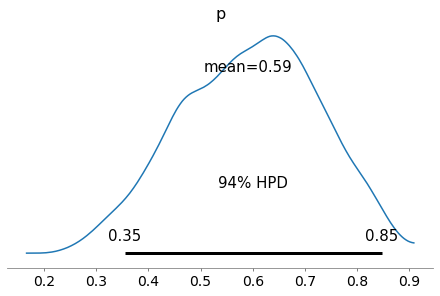

In [50]:
model = pm.Model()
with model:
    # Priors for unknown model parameters
    p = pm.Uniform('p')
    # Expected value of outcome
    y_obs = pm.Binomial('y', n=N, p=p, observed=x)

    # Sample from posterior distribution
    step = pm.NUTS()
    trace = pm.sample(1000, step)

ax = pm.plot_posterior(trace)

In [51]:
df_summary = pm.summary(trace).round(4)
df_summary.head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.59,0.135,0.355,0.847,0.005,0.004,643.0,643.0,673.0,1200.0,1.0


In [52]:
map = df_summary.iloc[0]['mean']
error = abs(true_p - map)
print('MAP Estimate = {}'.format(map))
print('Error = {:.2f}'.format(error))

MAP Estimate = 0.59
Error = 0.11


With only 5 samples, and no prior information, we get an estimated p=0.59. Let's us add some prior information. 

## Beta Prior - Prior with high chance of Heads. (appropriate prior)
Assuming we have some prior knowledge that the coin is biased, with a higher chance of getting Heads. 
We can use a Beta distribution with a peak near 1 (assume p=0.8) to model this prior. α=5, β=2 

Mean of beta distribution: 0.63


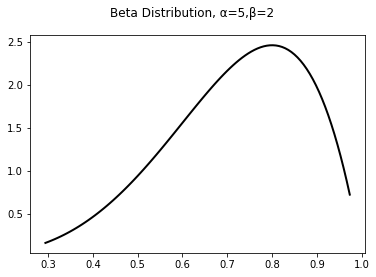

In [53]:
from scipy.stats import beta
fig, ax = plt.subplots(1, 1)
fig.suptitle('Beta Distribution, α=5,β=2')
a = 5
b = 2
beta_x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
beta_dist = beta(a,b)
ax.plot(beta_x, beta_dist.pdf(beta_x), 'k-', lw=2)
print('Mean of beta distribution: {:.2f}'.format(beta_x.mean()))

Sequential sampling (2 chains in 1 job)
NUTS: [p]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 2020.99it/s]
The acceptance probability does not match the target. It is 0.9003420554890943, but should be close to 0.8. Try to increase the number of tuning steps.


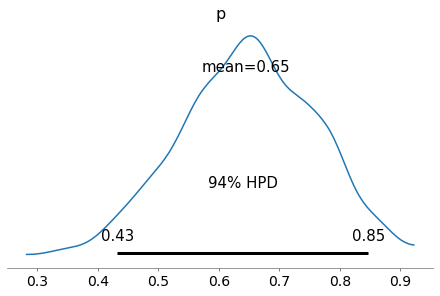

In [54]:
model = pm.Model()
with model:
    # Priors for unknown model parameters
    p = pm.Beta('p', alpha=a, beta=b)
    # Expected value of outcome
    y_obs = pm.Binomial('y', n=N, p=p, observed=x)

    # Sample from posterior distribution
    step = pm.NUTS()
    trace = pm.sample(1000, step)

ax = pm.plot_posterior(trace)

In [55]:
df_summary = pm.summary(trace).round(4)
df_summary.head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.645,0.111,0.432,0.847,0.004,0.003,717.0,717.0,726.0,1135.0,1.0


In [56]:
map = df_summary.iloc[0]['mean']
error = abs(true_p - map)
print('Mean of Beta distribution = {:.2f}, for α={}, β={}'.format(beta_dist.mean(),a,b))
print('MAP Estimate = {}'.format(map))
print('Error = {:.2f}'.format(error))

Mean of Beta distribution = 0.71, for α=5, β=2
MAP Estimate = 0.645
Error = 0.05


We see that with a suitable prior, the MAP estimate incorporates the prior, and brings us closer to the true p value of 0.7.

## Beta Prior - Prior with high chance of Tails (inappropriate prior)
What happens if our Prior knowledge is incorrect? Let us assume that the coin has a high chance of Tails. We use a Beta distribution with α=2, β=5 to model a p value that is close to 0 (p=0.2). 


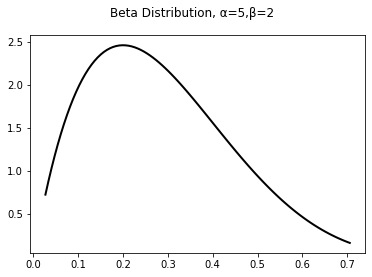

In [57]:
from scipy.stats import beta
fig, ax = plt.subplots(1, 1)
fig.suptitle('Beta Distribution, α=5,β=2')
a = 2
b = 5
beta_x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
beta_dist = beta(a,b)
ax.plot(beta_x, beta_dist.pdf(beta_x), 'k-', lw=2)

Sequential sampling (2 chains in 1 job)
NUTS: [p]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 1981.69it/s]


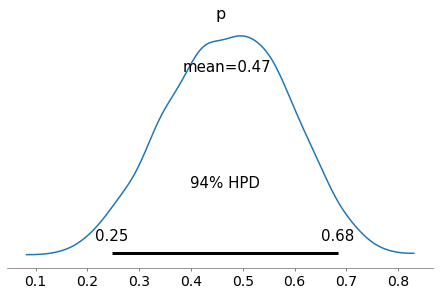

In [58]:
model = pm.Model()
with model:
    # Priors for unknown model parameters
    p = pm.Beta('p', alpha=a, beta=b)
    # Expected value of outcome
    y_obs = pm.Binomial('y', n=N, p=p, observed=x)

    # Sample from posterior distribution
    step = pm.NUTS()
    trace = pm.sample(1000, step)

ax = pm.plot_posterior(trace)

In [59]:
df_summary = pm.summary(trace).round(4)
df_summary.head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.47,0.119,0.248,0.684,0.004,0.003,878.0,878.0,888.0,1511.0,1.0


In [60]:
map = df_summary.iloc[0]['mean']
error = abs(true_p - map)
print('Mean of Beta distribution = {:.2f}, for α={}, β={}'.format(beta_dist.mean(),a,b))
print('MAP Estimate = {}'.format(map))
print('Error = {:.2f}'.format(error))

Mean of Beta distribution = 0.29, for α=2, β=5
MAP Estimate = 0.47
Error = 0.23


## Beta Prior - Prior with high chance of tails. (inappropriate prior, more data)
We saw above that if we provided the model with a prior that is the far away from the true value of p, the model performs poorly, and expectedly so. However, with sufficient data, this can be overcomed. Let us increase the number of data samples. 

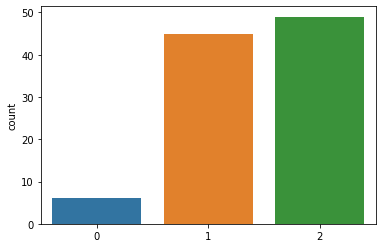

In [61]:
# Increase the amount of data collected from 5 to 100
num_samples = 100

# Generate random data based on true_theta
x = binomial(N, true_p, size=num_samples)
sns.countplot(x)

Sequential sampling (2 chains in 1 job)
NUTS: [p]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 1927.83it/s]


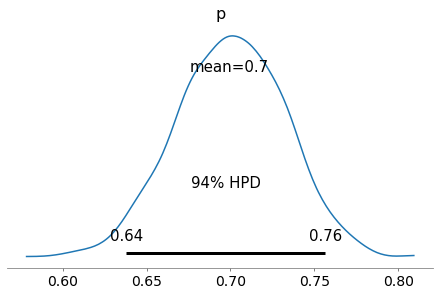

In [62]:
model = pm.Model()
with model:
    # Priors for unknown model parameters
    p = pm.Beta('p', alpha=a, beta=b)
    # Expected value of outcome
    y_obs = pm.Binomial('y', n=N, p=p, observed=x)

    # Sample from posterior distribution
    step = pm.NUTS()
    trace = pm.sample(1000, step)

ax = pm.plot_posterior(trace)

In [63]:
df_summary = pm.summary(trace).round(4)
df_summary.head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.7,0.032,0.638,0.756,0.001,0.001,752.0,747.0,753.0,1478.0,1.01


In [64]:
map = df_summary.iloc[0]['mean']
error = abs(true_p - map)
print('Mean of Beta distribution = {:.2f}, for α={}, β={}'.format(beta_dist.mean(),a,b))
print('MAP Estimate = {}'.format(map))
print('Error = {:.2f}'.format(error))

Mean of Beta distribution = 0.29, for α=2, β=5
MAP Estimate = 0.7
Error = 0.00


**Conclusion:** After increasing the amount of data we have, we see that the incorrect prior information has a lesser weightage in affecting the posterior / MAP, and is in fact quite close to the true value of p. 

###############################################

# Problem 2: Dice Throw (Multinomial Distribution)
**Problem Setup:**
We want to model the probability of picking out a series of categories from p possible discrete outcomes, through N experiments. We can think of this as throwing a 6-sided (p) dice, each sample being 2 dice throws, and repeating the experiment 5 times (N samples). 

*Another problem would be to predict the quality of a wine, from a discrete distribution of values ranging from 1 to 10. We go with dice throw here for simplicity.*

**Model:**
We can model this with a multinomial distribution, and a Dirichlet prior which is conjugate to the multinomial distribution. Our prior in this case, represent our knowledge about the concentration of colours in the bag. 

In [65]:
''' Define a Multinomial distribution, with a Dirichlet prior '''
np.random.seed(23)

# True parameter value - Biased dice, with a higher probability of landing on even numbers.
true_pvals = np.array([2/15, 1/5, 2/15, 1/5, 2/15, 1/5])
print('True p-values:', true_pvals)

# Sample size; ie. How many independent dice throws in one sample
k = 2

# Number of samples
N = 5

# Generate random data based on true_theta
x = multinomial(n=k, pvals=true_pvals, size=N)
# sns.countplot(x)

True p-values: [0.1333 0.2    0.1333 0.2    0.1333 0.2   ]


In [66]:
print('Sampled distribution:\n')
x

Sampled distribution:



array([[0, 2, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 1],
       [1, 1, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0]])

## Uniform Prior - Assume Fair Dice
We sample the data we have with MCMC 1000 times, to generate an estimate for the posterior. The MAP is then the peak of the posterior. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [parameters]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 1004.75it/s]


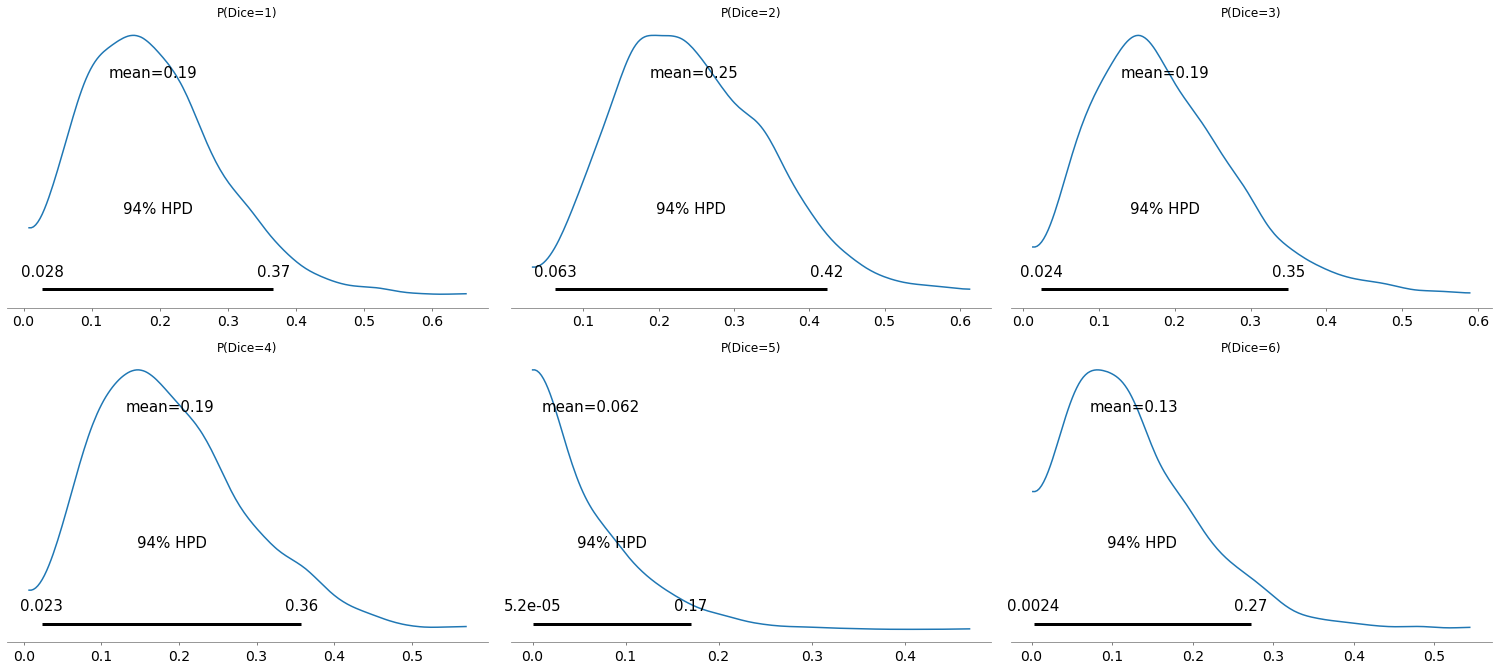

In [67]:
# We set the alpha parameters to be of equal weight of 1, to represent the un
alphas = np.array([1, 1, 1, 1, 1, 1])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet('parameters', a=alphas, shape=6)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial('observed_data', n=2, p=parameters, shape=6, observed=x)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)
for i in range(6):
  ax[i].set_title("P(Dice={})".format(i+1))

In [68]:
df_summary = pm.summary(trace).round(4)
df_summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
parameters[0],0.189,0.098,0.028,0.367,0.002,0.001,2739.0,2290.0,2685.0,1506.0,1.00
parameters[1],0.246,0.101,0.063,0.423,0.002,0.002,2176.0,2108.0,2106.0,1306.0,1.00
parameters[2],0.187,0.094,0.024,0.350,0.002,0.001,2485.0,2180.0,2509.0,1451.0,1.00
parameters[3],0.189,0.094,0.023,0.358,0.002,0.001,2577.0,2396.0,2473.0,1755.0,1.00
parameters[4],0.062,0.058,0.000,0.170,0.001,0.001,2340.0,1816.0,2282.0,1426.0,1.00
parameters[5],0.127,0.082,0.002,0.272,0.002,0.001,2407.0,1686.0,2687.0,1376.0,1.01


In [69]:
p_even = 0
p_odd = 0
true_p_even = 0
true_p_odd = 0

for i in range(6):
  map = df_summary.iloc[i]['mean']
  error = true_pvals[i] - map
  print('P(Dice landing on {}) = {}'.format(i, map))
  print('Error for Dice landing on {} = {:.2f}\n'.format(i, error))
  
  if (i+1)%2 == 0: 
    p_even += map
    true_p_even += true_pvals[i]  
  else:
    p_odd += map
    true_p_odd += true_pvals[i]

print('P(Even) = {:.2f} vs True_P(Even) = {:.2f}. Error for even dice throws = {:.2f}'.format(p_even, true_p_even, abs(p_even-true_p_even)))
print('P(Odd) = {:.2f} vs True_P(Odd) = {:.2f}. Error for even dice throws = {:.2f}'.format(p_odd, true_p_odd, abs(p_odd-true_p_odd)))

P(Dice landing on 0) = 0.189
Error for Dice landing on 0 = -0.06

P(Dice landing on 1) = 0.246
Error for Dice landing on 1 = -0.05

P(Dice landing on 2) = 0.187
Error for Dice landing on 2 = -0.05

P(Dice landing on 3) = 0.189
Error for Dice landing on 3 = 0.01

P(Dice landing on 4) = 0.062
Error for Dice landing on 4 = 0.07

P(Dice landing on 5) = 0.127
Error for Dice landing on 5 = 0.07

P(Even) = 0.56 vs True_P(Even) = 0.60. Error for even dice throws = 0.04
P(Odd) = 0.44 vs True_P(Odd) = 0.40. Error for even dice throws = 0.04


Given the relatively small sample size, relatively to the number of outcomes, it is not clear that even dice throws have a higher probability. However, when we sum up the proability of the even vs odd dice throws, it is clear that Even dice throws are more probable. 

## Dirichlet Prior - Prior with high chance of Even throws. (appropriate prior)
Assume we have prior knowledge that Even throws are more likely. 
We can adjust the weights on the Dirichlet prior to reflect this. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [parameters]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:02<00:00, 572.75it/s]


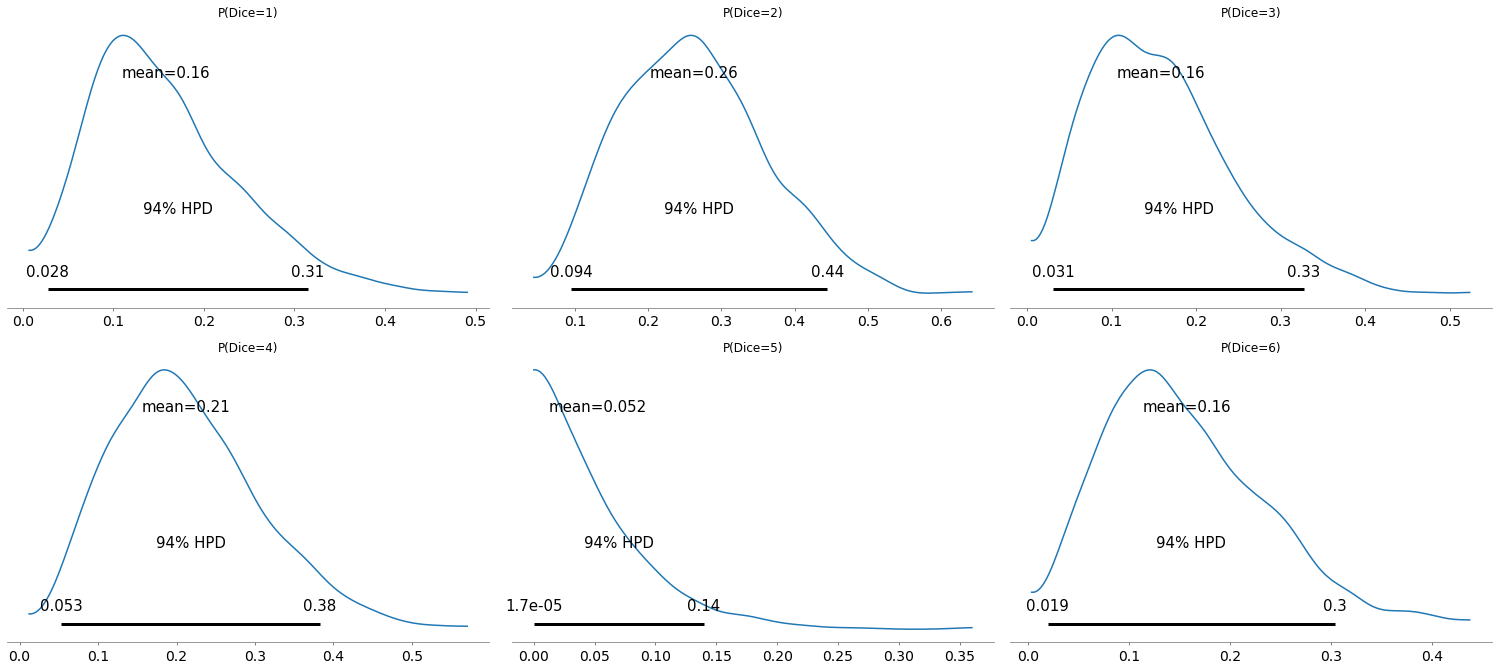

In [70]:
# We set the alpha parameters for even dice throws to be of higher weight. 
alphas = np.array([1, 2, 1, 2, 1, 2])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet('parameters', a=alphas, shape=6)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial('observed_data', n=2, p=parameters, shape=6, observed=x)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)
for i in range(6):
  ax[i].set_title("P(Dice={})".format(i+1))

In [71]:
df_summary = pm.summary(trace).round(4)
df_summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
parameters[0],0.158,0.082,0.028,0.315,0.002,0.001,2271.0,2185.0,1998.0,1314.0,1.0
parameters[1],0.263,0.098,0.094,0.445,0.002,0.001,2253.0,2187.0,2206.0,1419.0,1.0
parameters[2],0.159,0.085,0.031,0.327,0.002,0.001,2123.0,2059.0,2009.0,1500.0,1.0
parameters[3],0.211,0.093,0.053,0.383,0.002,0.001,2682.0,2273.0,2696.0,1724.0,1.0
parameters[4],0.052,0.049,0.000,0.139,0.001,0.001,2209.0,1541.0,2243.0,1213.0,1.0
parameters[5],0.157,0.081,0.019,0.304,0.002,0.001,2342.0,2041.0,2438.0,1639.0,1.0


In [72]:
p_even = 0
p_odd = 0
true_p_even = 0
true_p_odd = 0

for i in range(6):
  map = df_summary.iloc[i]['mean']
  error = true_pvals[i] - map
  print('P(Dice landing on {}) = {}'.format(i, map))
  print('Error for Dice landing on {} = {:.2f}\n'.format(i, error))
  
  if (i+1)%2 == 0: 
    p_even += map
    true_p_even += true_pvals[i]  
  else:
    p_odd += map
    true_p_odd += true_pvals[i]

print('P(Even) = {:.2f} vs True_P(Even) = {:.2f}. Error for even dice throws = {:.2f}'.format(p_even, true_p_even, abs(p_even-true_p_even)))
print('P(Odd) = {:.2f} vs True_P(Odd) = {:.2f}. Error for even dice throws = {:.2f}'.format(p_odd, true_p_odd, abs(p_odd-true_p_odd)))

P(Dice landing on 0) = 0.158
Error for Dice landing on 0 = -0.02

P(Dice landing on 1) = 0.263
Error for Dice landing on 1 = -0.06

P(Dice landing on 2) = 0.159
Error for Dice landing on 2 = -0.03

P(Dice landing on 3) = 0.211
Error for Dice landing on 3 = -0.01

P(Dice landing on 4) = 0.052
Error for Dice landing on 4 = 0.08

P(Dice landing on 5) = 0.157
Error for Dice landing on 5 = 0.04

P(Even) = 0.63 vs True_P(Even) = 0.60. Error for even dice throws = 0.03
P(Odd) = 0.37 vs True_P(Odd) = 0.40. Error for even dice throws = 0.03


With an appropriate prior, we see that the error has decreased slightly. 

## Dirichlet Prior - Prior with high chance of Odd throws (inappropriate prior)
What happens if our Prior knowledge is incorrect? This means we assume the dice has a high chance of being Odd. We can reverse the weights of the Dirichlet parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [parameters]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 900.80it/s]


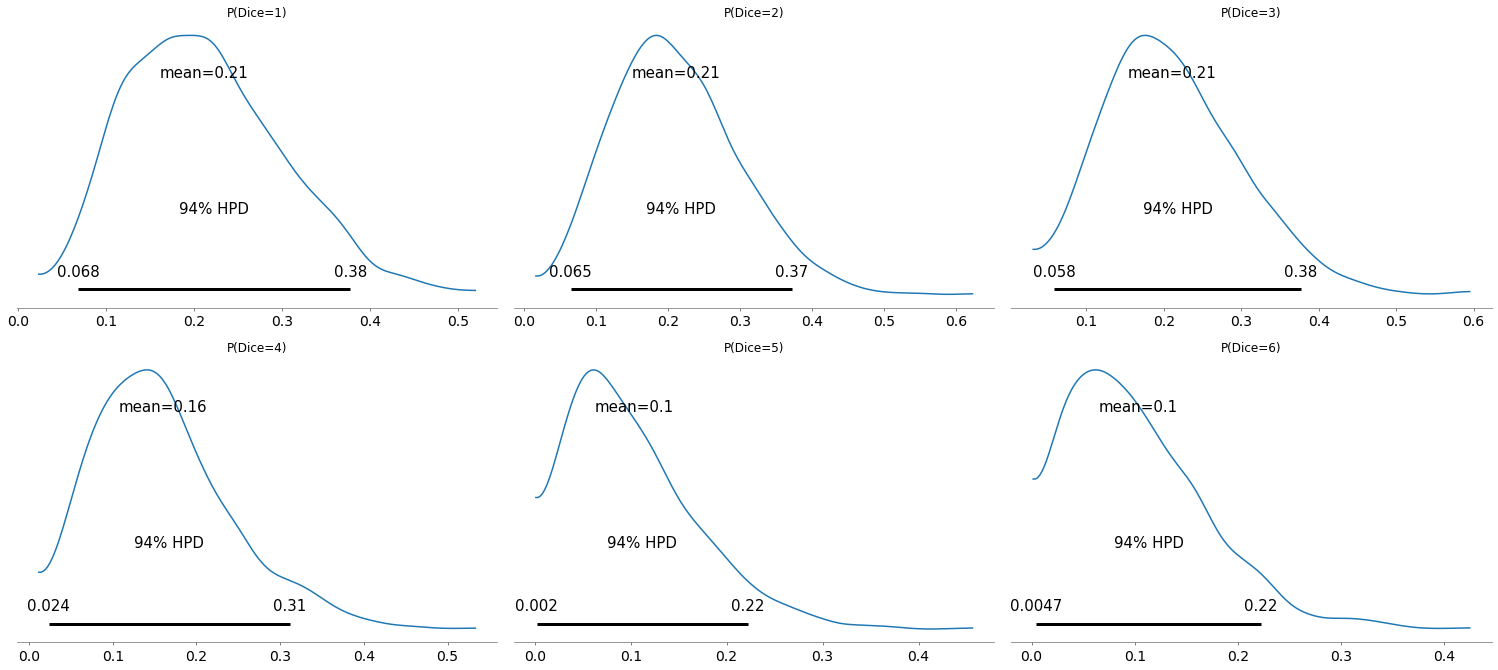

In [73]:
# We set the alpha parameters for ODD dice throws to be of higher weight. 
alphas = np.array([2, 1, 2, 1, 2, 1])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet('parameters', a=alphas, shape=6)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial('observed_data', n=2, p=parameters, shape=6, observed=x)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)
for i in range(6):
  ax[i].set_title("P(Dice={})".format(i+1))

In [74]:
df_summary = pm.summary(trace).round(4)
df_summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
parameters[0],0.212,0.088,0.068,0.378,0.002,0.001,2762.0,2659.0,2687.0,1374.0,1.0
parameters[1],0.211,0.086,0.065,0.372,0.002,0.001,2398.0,2210.0,2393.0,1749.0,1.0
parameters[2],0.211,0.088,0.058,0.377,0.002,0.001,2718.0,2491.0,2683.0,1616.0,1.0
parameters[3],0.160,0.081,0.024,0.312,0.002,0.001,1915.0,1647.0,1937.0,1455.0,1.0
parameters[4],0.104,0.067,0.002,0.222,0.001,0.001,2293.0,1949.0,2203.0,1468.0,1.0
parameters[5],0.104,0.067,0.005,0.222,0.002,0.001,1691.0,1566.0,1666.0,1503.0,1.0


In [75]:
p_even = 0
p_odd = 0
true_p_even = 0
true_p_odd = 0

for i in range(6):
  map = df_summary.iloc[i]['mean']
  error = true_pvals[i] - map
  print('P(Dice landing on {}) = {}'.format(i, map))
  print('Error for Dice landing on {} = {:.2f}\n'.format(i, error))
  
  if (i+1)%2 == 0: 
    p_even += map
    true_p_even += true_pvals[i]  
  else:
    p_odd += map
    true_p_odd += true_pvals[i]

print('P(Even) = {:.2f} vs True_P(Even) = {:.2f}. Error for even dice throws = {:.2f}'.format(p_even, true_p_even, abs(p_even-true_p_even)))
print('P(Odd) = {:.2f} vs True_P(Odd) = {:.2f}. Error for even dice throws = {:.2f}'.format(p_odd, true_p_odd, abs(p_odd-true_p_odd)))

P(Dice landing on 0) = 0.212
Error for Dice landing on 0 = -0.08

P(Dice landing on 1) = 0.211
Error for Dice landing on 1 = -0.01

P(Dice landing on 2) = 0.211
Error for Dice landing on 2 = -0.08

P(Dice landing on 3) = 0.16
Error for Dice landing on 3 = 0.04

P(Dice landing on 4) = 0.104
Error for Dice landing on 4 = 0.03

P(Dice landing on 5) = 0.104
Error for Dice landing on 5 = 0.10

P(Even) = 0.47 vs True_P(Even) = 0.60. Error for even dice throws = 0.13
P(Odd) = 0.53 vs True_P(Odd) = 0.40. Error for even dice throws = 0.13


We see that with an inappropriate prior, the error is increased. Because we have too little data, the prior has a heavy weightage, and the MAP tells us it is more likely to obtain an Odd throw than Even, which is incorrect. 

## Dirichlet Prior - Prior with high chance of tails. (inappropriate prior, more data)
Let us increase the number of data samples, to see the effect of more data on an inappropriate prior. 

In [0]:
''' Define a Multinomial distribution, with a Dirichlet prior '''
np.random.seed(23)
N = 100

# Generate random data based on true_theta
x = multinomial(n=k, pvals=true_pvals, size=N)

<BarContainer object of 6 artists>

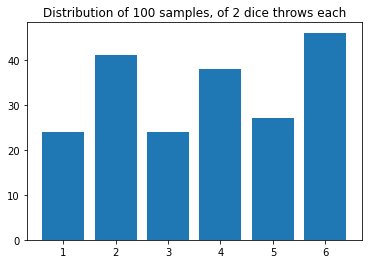

In [77]:
labels = [1,2,3,4,5,6]
x_sum = x.sum(axis=0)
fig, ax = plt.subplots()
ax.set_title('Distribution of 100 samples, of 2 dice throws each')
ax.bar(labels,x_sum)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [parameters]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 983.29it/s] 


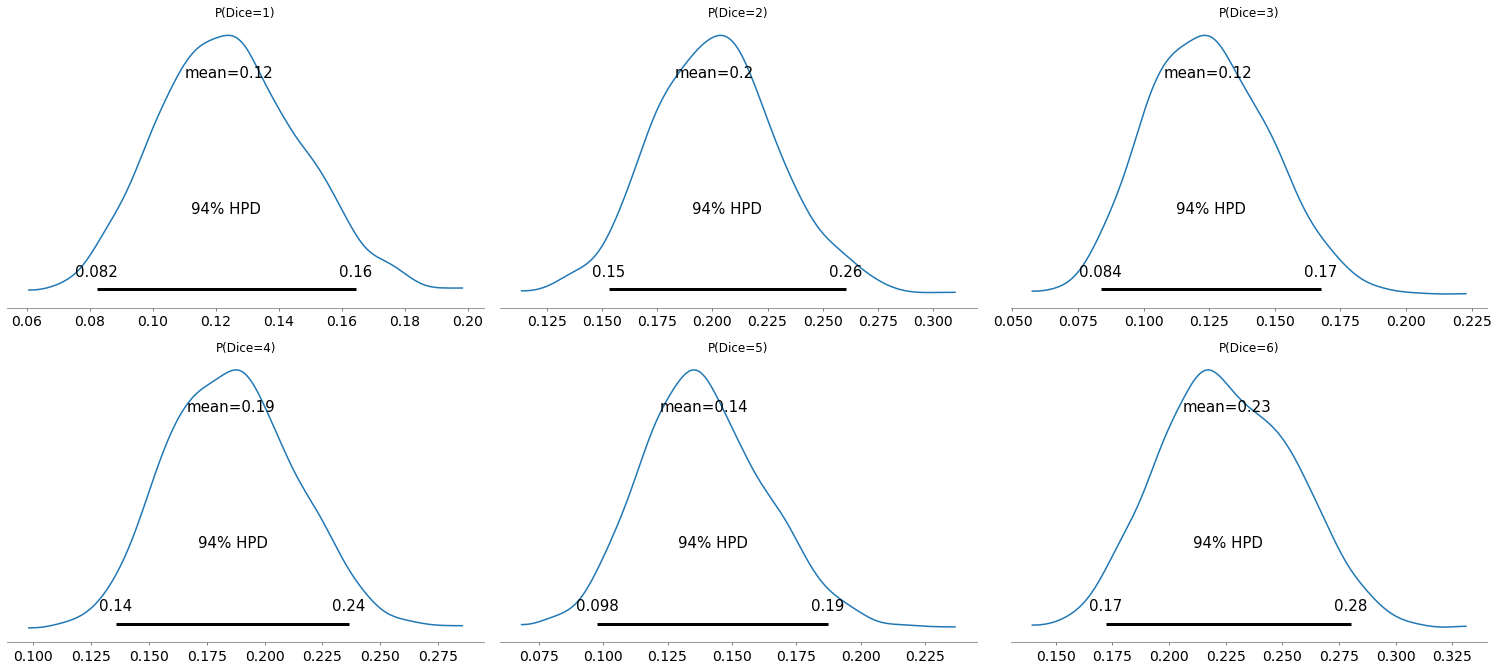

In [78]:
# We set the alpha parameters for ODD dice throws to be of higher weight. 
alphas = np.array([2, 1, 2, 1, 2, 1])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet('parameters', a=alphas, shape=6)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial('observed_data', n=2, p=parameters, shape=6, observed=x)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)
for i in range(6):
  ax[i].set_title("P(Dice={})".format(i+1))

In [79]:
df_summary = pm.summary(trace).round(4)
df_summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
parameters[0],0.124,0.023,0.082,0.165,0.000,0.0,3446.0,3342.0,3404.0,1405.0,1.0
parameters[1],0.201,0.029,0.153,0.260,0.001,0.0,2950.0,2950.0,2865.0,1485.0,1.0
parameters[2],0.125,0.023,0.084,0.168,0.000,0.0,3243.0,3243.0,3134.0,1438.0,1.0
parameters[3],0.185,0.028,0.136,0.236,0.000,0.0,3903.0,3709.0,3941.0,1667.0,1.0
parameters[4],0.139,0.024,0.098,0.187,0.000,0.0,2967.0,2864.0,3003.0,1792.0,1.0
parameters[5],0.226,0.030,0.172,0.280,0.000,0.0,3567.0,3468.0,3545.0,1814.0,1.0


In [80]:
p_even = 0
p_odd = 0
true_p_even = 0
true_p_odd = 0

for i in range(6):
  map = df_summary.iloc[i]['mean']
  error = true_pvals[i] - map
  print('P(Dice landing on {}) = {}'.format(i, map))
  print('Error for Dice landing on {} = {:.2f}\n'.format(i, error))
  
  if (i+1)%2 == 0: 
    p_even += map
    true_p_even += true_pvals[i]  
  else:
    p_odd += map
    true_p_odd += true_pvals[i]

print('P(Even) = {:.2f} vs True_P(Even) = {:.2f}. Error for even dice throws = {:.2f}'.format(p_even, true_p_even, abs(p_even-true_p_even)))
print('P(Odd) = {:.2f} vs True_P(Odd) = {:.2f}. Error for even dice throws = {:.2f}'.format(p_odd, true_p_odd, abs(p_odd-true_p_odd)))

P(Dice landing on 0) = 0.124
Error for Dice landing on 0 = 0.01

P(Dice landing on 1) = 0.201
Error for Dice landing on 1 = -0.00

P(Dice landing on 2) = 0.125
Error for Dice landing on 2 = 0.01

P(Dice landing on 3) = 0.185
Error for Dice landing on 3 = 0.02

P(Dice landing on 4) = 0.139
Error for Dice landing on 4 = -0.01

P(Dice landing on 5) = 0.226
Error for Dice landing on 5 = -0.03

P(Even) = 0.61 vs True_P(Even) = 0.60. Error for even dice throws = 0.01
P(Odd) = 0.39 vs True_P(Odd) = 0.40. Error for even dice throws = 0.01


With more data, the weightage on prior is lesser, and we see that the error rate have gone down significantly. 

###############################################

# Problem 3: Normal Distribution
Finally, let us examine a Normally distributed random variable, and the effect of the prior on the MAP / Posterior. 

**Model and Problem Setup:**
Many random variables in the real world are normally distributed. For example, we want to predict the selling price of a house.

Sample Mean = 10.134303756066235


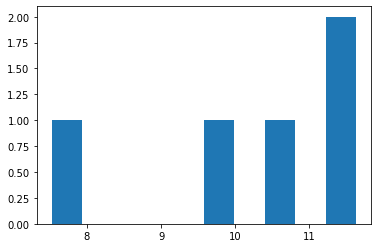

In [111]:
np.random.seed(100)
# Define a Normal distribution, with a Normal prior
# True parameter values
true_mu = 10 # Re-scaled mean selling price of a house
true_sigma = 2

# size of dataset
N = 5

# Generate random data based on true parameter values
x = np.sqrt(true_sigma)*randn(N,1) + true_mu
plt.hist(x)

print('Sample Mean = {}'.format(x.mean()))

## Uniform Prior - No prior knowledge. 
We try the uniform distribution, even though it is an improper prior. Resulting distribution does not integrate to 1. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 1, 626 divergences: 100%|██████████| 1500/1500 [00:06<00:00, 235.27it/s]
There were 633 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8932618168302613, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1260 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9131960974101612, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


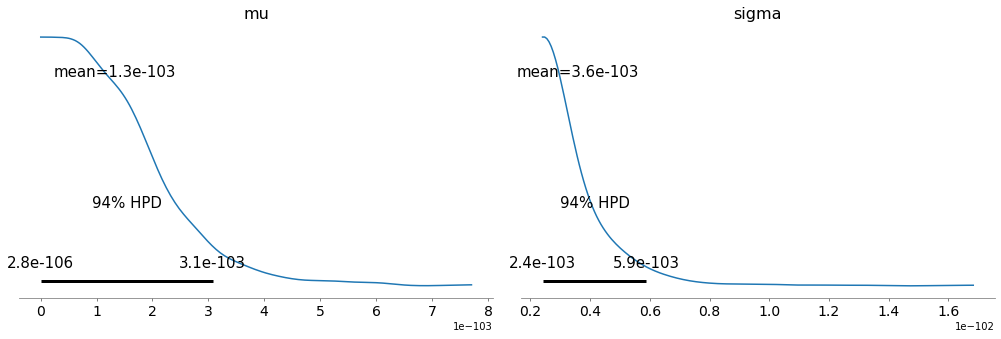

In [112]:
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Uniform('mu')
    sigma = pm.Uniform('sigma')
    
    mu = mu + x
    
    # Expected value of outcome
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=x)

    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)

In [113]:
df_summary = pm.summary(trace).round(4)
df_summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,247.0,263.0,1.01
sigma,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,142.0,359.0,1.01


The uniform prior is an improper prior for the Normal distribution. We can see the results are unexplainable and nowhere close to our true parameter values. It is an improper prior because the resulting distribution does not integrate to 1. 

## Normal Prior (appropriate mean value)
Next we try a Normal prior, with some knowledge about the value of mu. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1296.82it/s]


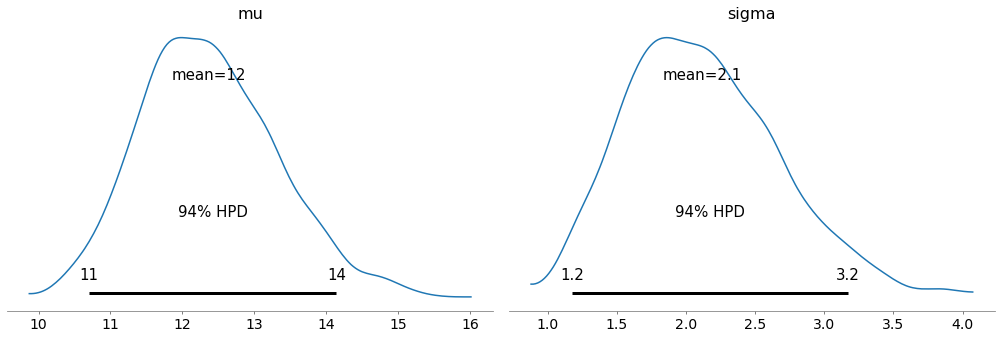

In [114]:
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', mu=15, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value of outcome
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=x)

    trace = pm.sample(draws=1000, chains=2, tune=1000, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)

In [115]:
df_summary = pm.summary(trace).round(4)
df_summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,12.364,0.940,10.703,14.141,0.035,0.025,731.0,731.0,720.0,913.0,1.0
sigma,2.119,0.552,1.177,3.170,0.020,0.014,742.0,742.0,718.0,673.0,1.0


In [116]:
map_estimate_mu = df_summary.loc['mu']['mean']
map_estimate_sigma = df_summary.loc['sigma']['mean']

print('MAP Estimate for mu = {:.4f}'.format(df_summary.loc['mu']['mean']))
print('Error = {:.2f}\n'.format(abs(true_mu-map_estimate_mu)))

print('MAP Estimate for sigma = {:.4f}'.format(df_summary.loc['sigma']['mean']))
print('Error = {:.2f}'.format(abs(true_sigma-map_estimate_sigma)))

MAP Estimate for mu = 12.3640
Error = 2.36

MAP Estimate for sigma = 2.1190
Error = 0.12


With an appropriate prior, we see that the MAP lies between the true mean, and the mean of our prior, which is expected. 

## Gamma Prior (inappropriate prior)
Here let us assume we use a gamma prior, with a peak at 4. 

$γ$~$(α=9, β=0.5)$

Mean of gamma distribution: 4.39


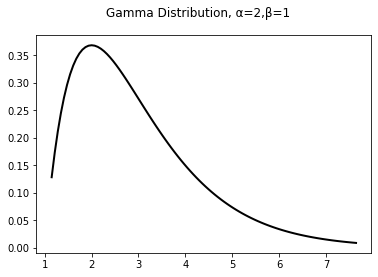

In [117]:
# Gamma distribution
from scipy.stats import gamma
fig, ax = plt.subplots(1, 1)
fig.suptitle('Gamma Distribution, α=2,β=1')
a = 2
b = 1
gamma_x = np.linspace(gamma.ppf(0.01, a, b),
                      gamma.ppf(0.99, a, b), 100)
gamma_dist = gamma(a,b)
ax.plot(gamma_x, gamma_dist.pdf(gamma_x), 'k-', lw=2)
print('Mean of gamma distribution: {:.2f}'.format(gamma_x.mean()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1390.02it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


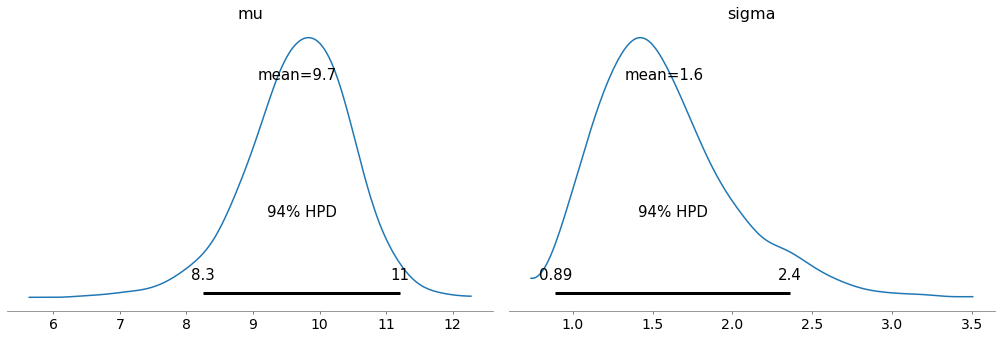

In [118]:
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Gamma('mu', alpha=a, beta=b)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value of outcome
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=x)

    trace = pm.sample(draws=1000, chains=2, tune=1000, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)

In [119]:
df_summary = pm.summary(trace).round(4)
df_summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,9.660,0.796,8.253,11.209,0.029,0.02,768.0,768.0,874.0,598.0,1.0
sigma,1.573,0.420,0.890,2.360,0.014,0.01,912.0,885.0,947.0,1092.0,1.0


In [120]:
map_estimate_mu = df_summary.loc['mu']['mean']
map_estimate_sigma = df_summary.loc['sigma']['mean']

print('MAP Estimate for mu = {:.4f}'.format(df_summary.loc['mu']['mean']))
print('Error = {:.2f}\n'.format(abs(true_mu-map_estimate_mu)))

print('MAP Estimate for sigma = {:.4f}'.format(df_summary.loc['sigma']['mean']))
print('Error = {:.2f}'.format(abs(true_sigma-map_estimate_sigma)))

MAP Estimate for mu = 9.6600
Error = 0.34

MAP Estimate for sigma = 1.5730
Error = 0.43


Again, we see that inappropriate prior information, with little data brings us further from the true parameter values. 

## Gamma Prior (inappropriate prior, with more data)
Here we increase the amount of data we have, to examine effects of an inappropriate prior. We use the same gamma prior $γ$~$(α=9, β=0.5)$

Recall: Our true mean was 10, and true std was 2. 

Sample Mean = 9.852687236757552


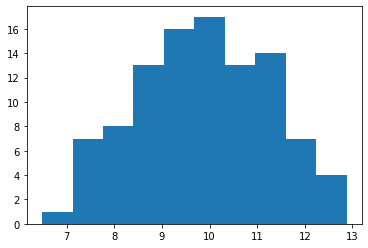

In [121]:
np.random.seed(100)

# size of dataset
N = 100

# Generate random data based on true parameter values
x = np.sqrt(true_sigma)*randn(N,1) + true_mu
plt.hist(x)

print('Sample Mean = {}'.format(x.mean()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1285.53it/s]


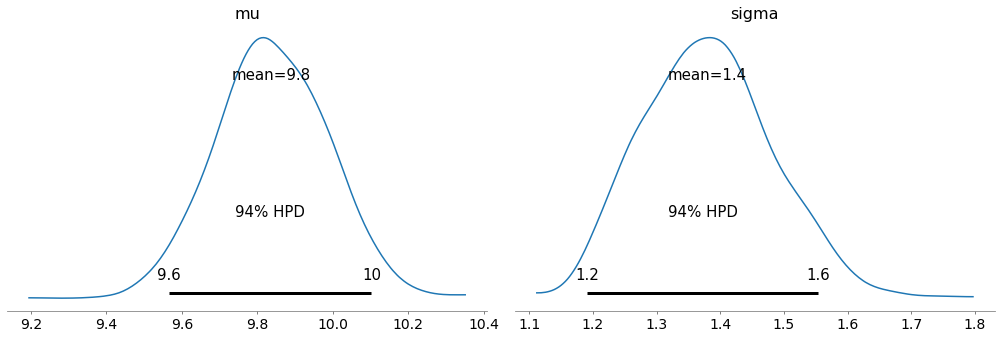

In [122]:
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Gamma('mu', alpha=a, beta=b)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value of outcome
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=x)

    trace = pm.sample(draws=1000, chains=2, tune=1000, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)

In [123]:
df_summary = pm.summary(trace).round(4)
df_summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,9.837,0.145,9.566,10.103,0.003,0.002,1848.0,1847.0,1852.0,1548.0,1.0
sigma,1.380,0.101,1.190,1.554,0.002,0.002,1709.0,1709.0,1677.0,1270.0,1.0


In [124]:
map_estimate_mu = df_summary.loc['mu']['mean']
map_estimate_sigma = df_summary.loc['sigma']['mean']

print('MAP Estimate for mu = {:.4f}'.format(df_summary.loc['mu']['mean']))
print('Error = {:.2f}\n'.format(abs(true_mu-map_estimate_mu)))

print('MAP Estimate for sigma = {:.4f}'.format(df_summary.loc['sigma']['mean']))
print('Error = {:.2f}'.format(abs(true_sigma-map_estimate_sigma)))

MAP Estimate for mu = 9.8370
Error = 0.16

MAP Estimate for sigma = 1.3800
Error = 0.62


With more data, we see less weightage placed on our choice of prior, and MAP estimates tend to the true value of mu and sigma. 